In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

DATADIR = Path('./Data')

net = cv2.dnn.readNetFromCaffe(str(Path('./caffe/deploy.prototxt')), str(Path('./caffe/res10_300x300_ssd_iter_140000.caffemodel')))

def detect_face(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):

        confidence = detections[0, 0, i, 2]

        if confidence > 0.7:

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, w, h) = box.astype("int")
            
            return image[y:h, x:w]
        
        return None

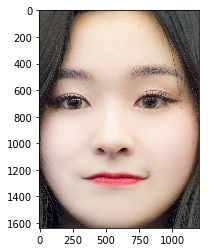

--------------------------------------------------------------------------------
With haar cascade:



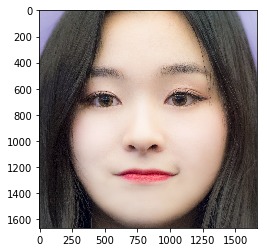

In [36]:
img = DATADIR / 'Gahyeon' / '3151.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face = detect_face(color_img)
if face is not None:
    plt.imshow(face)
    plt.show()
    
print('-' * 80)

# import no longer works due to file rename 
import nbimporter
import dc_learning_haar_cascade

haar_detect_face = dc_learning_haar_cascade.detect_face

img = DATADIR / 'Gahyeon' / '3151.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face, rect = haar_detect_face(color_img)
print('With haar cascade:\n')
if face is not None:
    plt.imshow(face)
    plt.show()
else:
    print('No faces found')

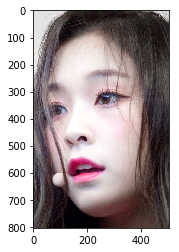

--------------------------------------------------------------------------------
With haar cascade:



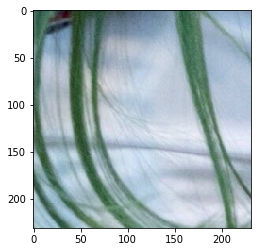

In [118]:
img = DATADIR / 'Gahyeon' / '4920.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face = detect_face(color_img)
if face is not None:
    plt.imshow(face)
    plt.show()
    
print('-' * 80)

img = DATADIR / 'Gahyeon' / '4920.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face, rect = haar_detect_face(color_img)
print('With haar cascade:\n')
if face is not None:
    plt.imshow(face)
    plt.show()
else:
    print('No faces found')

With caffe face detector:


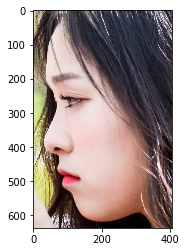

--------------------------------------------------------------------------------
With haar cascade:

No faces found


In [35]:
img = DATADIR / 'Gahyeon' / '2999.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face = detect_face(color_img)
print('With caffe face detector:')
if face is not None:
    plt.imshow(face)
    plt.show()
    
print('-' * 80)

img = DATADIR / 'Gahyeon' / '2999.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face, rect = haar_detect_face(color_img)
print('With haar cascade:\n')
if face is not None:
    plt.imshow(face)
    plt.show()
else:
    print('No faces found')

In [38]:
import random

IMG_SIZE = 100

def a_generator():
    """a generator that randomly pulls images from the Data directory, processes them with cv2, and yields them"""
    gahyeon = iter((DATADIR / 'Gahyeon').iterdir())
    handong = iter((DATADIR / 'Handong').iterdir())
    data_dict = {0: gahyeon, 1: handong}
    name_dict = {'Gahyeon':0, 'Handong':1}
    for i in range(10409):
        r = random.randint(0, 1)
        try:
            p = next(data_dict[r])
        except StopIteration:
            p = next(data_dict[1-r])
        
        try:
            img_array = cv2.imread(str(p))
            color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            face = detect_face(color_img)
            if face is not None:
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                yield face, name_dict[p.parent.name]
        except Exception:
            pass
    return

In [39]:
import time

X = []
y = []

start_time = time.time()

for i, (features, label) in enumerate(a_generator(), 1): 
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(f"Found {i} faces in {time.time() - start_time:.4f} sec")

Found 10015 faces in 1427.3298 sec


In [40]:
import pickle

save_path = Path('./Models/Caffe')

with open(save_path / 'X.pickle', 'wb') as file:
    pickle.dump(X, file)
    
with open(save_path / 'y.pickle', 'wb') as file:
    pickle.dump(y, file)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

path = Path('./Models/Caffe')

with open(path / 'X.pickle', 'rb') as X_file:
    X = pickle.load(X_file)
    
with open(path / 'y.pickle', 'rb') as y_file:
    y = pickle.load(y_file)
    
X = X / 255.0

name = f"3-conv-128-nodes-{int(time.time())}"

tensorboard = TensorBoard(log_dir=path / 'logs' / f"{name}")

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape = X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for i in range(2):
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.fit(X, y, batch_size=24, epochs=10, validation_split=0.05, callbacks=[tensorboard])

model.save(path / 'gahyeon-handong.model')

Train on 9514 samples, validate on 501 samples
Epoch 1/10
9514/9514 [==============================] - 15s 2ms/sample - loss: 0.3346 - acc: 0.8452 - val_loss: 0.2142 - val_acc: 0.9122
Epoch 2/10
9514/9514 [==============================] - 15s 2ms/sample - loss: 0.1504 - acc: 0.9435 - val_loss: 0.2154 - val_acc: 0.9122
Epoch 3/10
9514/9514 [==============================] - 16s 2ms/sample - loss: 0.1071 - acc: 0.9583 - val_loss: 0.1576 - val_acc: 0.9341
Epoch 4/10
9514/9514 [==============================] - 15s 2ms/sample - loss: 0.0756 - acc: 0.9732 - val_loss: 0.1832 - val_acc: 0.9321
Epoch 5/10
9514/9514 [==============================] - 16s 2ms/sample - loss: 0.0646 - acc: 0.9766 - val_loss: 0.1518 - val_acc: 0.9441
Epoch 6/10
9514/9514 [==============================] - 15s 2ms/sample - loss: 0.0450 - acc: 0.9833 - val_loss: 0.1076 - val_acc: 0.9601
Epoch 7/10
9514/9514 [==============================] - 15s 2ms/sample - loss: 0.0383 - acc: 0.9872 - val_loss: 0.1456 - val_acc: 0

In [48]:
IMG_SIZE = 100

categories = ['Gahyeon', 'Handong']

path = Path('./Data/test')
            
X_test = []
y_test = []
            
for p in path.iterdir():
    try:
        img_array = cv2.imread(str(p))
        color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        face = detect_face(color_img)
        if face is not None:
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            X_test.append(face)
            y_test.append(categories[int(p.name[0])])
    except Exception:
        pass

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [54]:
import tensorflow.keras.models

model = tensorflow.keras.models.load_model(Path('./Models/Caffe/gahyeon-handong.model'))

prediction = model.predict([X_test])

correct = 0; gah_correct = 0; han_correct = 0
total = len(y_test); gah_total = len([i for i in y_test if i == "Gahyeon"]); han_total = total - gah_total

for p, actual in zip(prediction.flatten().tolist(), y_test):
    if categories[int(p)] == actual:
        correct += 1
        if actual == 'Gahyeon':
            gah_correct += 1
        else:
            han_correct += 1

print(f"""gahyeon: {{correct: {gah_correct}, total: {gah_total}, acc: {gah_correct/gah_total * 100:2.4f}%}}
handong: {{correct: {han_correct}, total: {han_total}, acc: {han_correct/han_total * 100:2.4f}%}}
overall: {{correct: {correct}, total: {total}, acc: {correct/total * 100:2.4f}%}}""")

gahyeon: {correct: 136, total: 163, acc: 83.4356%}
handong: {correct: 184, total: 185, acc: 99.4595%}
overall: {correct: 320, total: 348, acc: 91.9540%}
